# Working with Neural networks

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## convert MNIST dataset image to tensors

In [9]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

In [23]:
train_data, test_data, type(test_data)

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ../data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ../data
     Split: Test
     StandardTransform
 Transform: ToTensor(),
 torchvision.datasets.mnist.MNIST)

In [38]:
image, label = train_data[2]
image.shape
# note only 1 channel indicates greyscale image
# 28, 28 is the size of the original binary array

torch.Size([1, 28, 28])

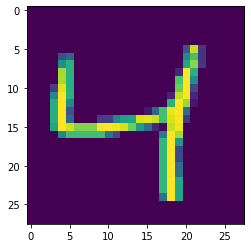

In [39]:
# we can drop the uninformative first channel
plt.imshow(image.reshape((28, 28)))

In [41]:
# we will load data in batches, but randomly
torch.manual_seed(101)

# 100 images per batch, fetched randomly from dataset
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

# visualize what these image batches look like


In [44]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [45]:
# first batch

for images, labels in train_loader:
    print(images, images.shape)
    break


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [49]:
im.shape

torch.Size([3, 32, 362])

tensor([7, 2, 3, 5, 8, 5, 3, 6, 9, 9, 1, 3])

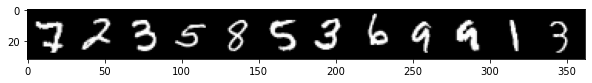

In [55]:
# print first 12 images
im = make_grid(images[:12], nrow=12)
# currently im contains color-width-height channel format
plt.figure(figsize=(10, 4))
# plt imshow expects width-height-color channel
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
labels[:12]
# (1,2,0) is the index of the WHC as expected

In [56]:
# defining our model

class MultiLayerPerceptron(nn.Module):
    # input is a long input layer [28*28]
    # output is 10 neuron layer [0-9 labels]
    # hidden layers have 120 and 84 resp. (arbit)
    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84]):
        super().__init__()
        # fully connected layers between input and hidden and output
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
    
    def forward(self, X):
        # this function passes the input features forward
        # X is our data feature
        # F contains our relu (rectified linear unit)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        # multi class classification needs single dimension output
        return F.log_softmax(X, dim=1)

In [57]:
torch.manual_seed(101)
model = MultiLayerPerceptron()
model

MultiLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [61]:
# we can visualize all connections from input array 
# begins with 784 neurons connecting to 120 (=94080) and so on
for param in model.parameters():
    print(param.numel())
# In total 105214 parameters being controlled by this ANN
# each with its own biases but in CNN, this reduces

94080
120
10080
84
840
10


In [62]:
# defining loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [64]:
# We want to convert the shape of the images 
images.shape # (100,1,28,28) -> (100, 784)
# -1 considers rest of the axes together in view
images.view(100, -1).shape

torch.Size([100, 784])